In [1]:
# cmd = "sed -i -e 's/ \/ / \/\/ /' timm-efficientdet-pytorch/effdet/bench.py"
# !$cmd

In [2]:
import sys
sys.path.insert(0, "timm-efficientdet-pytorch")
sys.path.insert(0, "omegaconf")

from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")    

In [4]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [5]:
DATA_ROOT_PATH = '/home/thinh/nfl/images'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [6]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [7]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval()
    return net.to(device)

net = load_net('/home/thinh/nfl/effdet5-models/helmet-detect-last-checkpoint.bin')

In [8]:
def make_predictions(images, score_threshold=0.22):
    images = torch.stack(images).to(device).float()
    predictions = []
    
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().to(device))
        
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return predictions

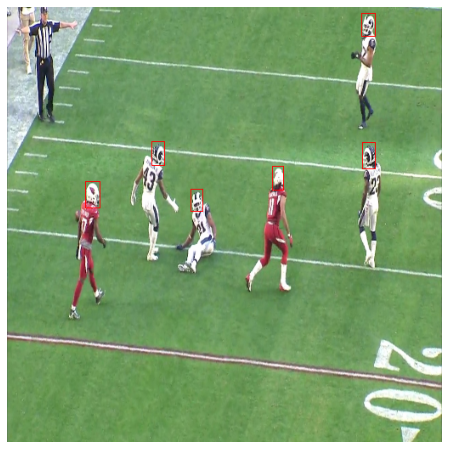

In [9]:
for j, (images, image_ids) in enumerate(data_loader):
    break

predictions = make_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores = predictions[i]['boxes'], predictions[i]['scores']
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample);

In [10]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [12]:
results = []

for images, image_ids in data_loader:
    predictions = make_predictions(images)
    
    for i, image in enumerate(images):
#         boxes, scores = run_wbf(predictions, image_index=i)
        boxes, scores = predictions[i]['boxes'], predictions[i]['scores']
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [13]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('image_predict_helmet.csv', index=False)
test_df.head()

,image_id,PredictionString
0,57802_001937_Endzone_frame303,0.5773 185 411 33 61 0.5357 341 316 30 56 0.52...
1,57814_002782_Endzone_frame22,0.5969 433 631 24 52 0.5075 348 383 25 50 0.44...
2,57594_000566_Endzone_frame371,0.5532 735 514 30 62 0.4782 98 265 45 61 0.476...
3,58114_000219_Sideline_frame1174,0.5174 786 557 6 14 0.4924 467 377 6 16 0.4734...
4,57798_001594_Endzone_frame81,0.6201 140 196 25 53 0.5000 192 405 23 38 0.49...
